# Adult Census Income Prediction

This project is part of the **Machine Learning Zoomcamp** by DataTalksClub.

The goal is to build a machine learning model that predicts whether a person
earns more than **$50K per year** based on demographic and employment data
from the Adult Census dataset.


## Dataset

We use the **Adult Census Income** dataset.

- Source: UCI / Kaggle
- Target variable: `income` (`>50K` or `<=50K`)

### How to get the data

1. Download the dataset from:
   https://www.kaggle.com/datasets/uciml/adult-census-income
2. Place the CSV file in:



In [16]:
%pip install -qq pandas numpy matplotlib seaborn scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


### Data Loading

In this section, the **Adult Census Income dataset** is loaded directly from the UCI Machine Learning Repository. First, the URL pointing to the raw data file is defined. Then, a list of column names is manually specified to label each variable, since the original dataset does not include headers.

The dataset is read using `pandas.read_csv`, specifying that the file has no header row and assigning the predefined column names. The character `"?"` is interpreted as a missing value and converted to `NaN`, while `skipinitialspace=True` is used to remove leading spaces after delimiters.

Finally, the `head()` method is called to display the first rows of the dataset and verify that the data has been loaded correctly.


In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country",
    "income"
]

df = pd.read_csv(
    url,
    header=None,
    names=columns,
    na_values="?",
    skipinitialspace=True
)

df.head()


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Data Cleaning and Preprocessing

In this step, several preprocessing operations are applied to prepare the dataset for modeling. First, all column names are standardized by removing leading and trailing spaces, converting them to lowercase, and replacing spaces with underscores. This ensures consistency and improves usability when referencing variables.

Next, missing values are handled by replacing the `"?"` character with `NaN` and removing all rows that contain missing data. This results in a clean dataset with complete observations only.

Finally, the target variable `income` is transformed into a binary numerical format, where individuals earning more than 50K dollars per year are encoded as `1`, and those earning $50K or less are encoded as `0`. After these preprocessing steps, the resulting dataset contains **30,162 rows and 15 columns**, which is confirmed by checking the dataset shape.


In [3]:
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
    )

    df = df.replace("?", np.nan)
    df = df.dropna()

    df["income"] = df["income"].apply(lambda x: 1 if x == ">50K" else 0)

    df.shape


(30162, 15)

### Exploratory Data Analysis (EDA)

As part of the exploratory data analysis, the distribution of the target variable `income` was examined using normalized value counts. The results show that approximately **75.1%** of individuals in the dataset earn **$50K or less per year**, while **24.9%** earn **more than $50K per year**.

This indicates a **moderate class imbalance** in the target variable, which is an important consideration for model training and evaluation. Due to this imbalance, accuracy alone may not be a sufficient performance metric, and additional evaluation metrics such as precision, recall, F1-score, or AUC should be considered to better assess model performance.



In [4]:
df["income"].value_counts(normalize=True)


income
0    0.751078
1    0.248922
Name: proportion, dtype: float64

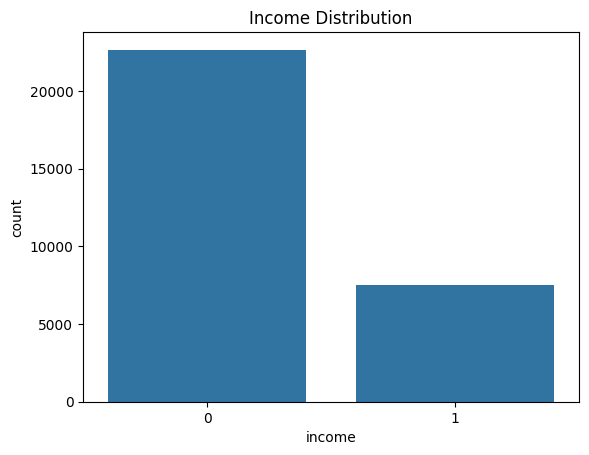

In [5]:
sns.countplot(x="income", data=df)
plt.title("Income Distribution")
plt.show()


### Income Distribution by Education Level

To analyze the relationship between education and income, the dataset was grouped by the `education` variable and the mean of the binary target variable `income` was computed for each category. Since `income` is encoded as `1` for individuals earning more than \$50K and `0` otherwise, the mean value represents the **proportion of individuals within each education level who earn more than \$50K per year**.

The results show a clear and consistent pattern: **higher levels of education are strongly associated with higher income**. Advanced degrees such as *Professional School*, *Doctorate*, and *Master’s* exhibit the highest proportions of individuals earning more than $50K, with values close to or above 0.55. In contrast, lower educational levels, including incomplete primary education and preschool, show very low or zero proportions.

This trend is expected and aligns with socio-economic theory, as higher educational attainment is typically associated with better job opportunities, higher-skilled occupations, and increased earning potential. From a machine learning perspective, this analysis suggests that `education` is a **highly informative feature** for predicting income and is likely to have strong predictive power in the model.

Additionally, the monotonic relationship observed across education levels indicates that education-related features may also benefit from ordinal encoding or aggregation into broader education categories, depending on the modeling approach.


In [6]:
df.groupby("education")["income"].mean().sort_values(ascending=False)


education
Prof-school     0.749077
Doctorate       0.746667
Masters         0.564229
Bachelors       0.421491
Assoc-voc       0.263198
Assoc-acdm      0.253968
Some-college    0.200060
HS-grad         0.164329
12th            0.076923
10th            0.071951
7th-8th         0.062837
11th            0.056298
9th             0.054945
5th-6th         0.041667
1st-4th         0.039735
Preschool       0.000000
Name: income, dtype: float64

### Income by Occupation

To further explore the relationship between occupation and income, the dataset was grouped by the `occupation` variable and the mean of the binary target `income` was calculated for each category. This value represents the proportion of individuals earning more than $50K per year within each occupation.

The results indicate substantial variation across occupational groups. Executive, managerial, and professional roles such as *Exec-managerial* and *Prof-specialty* show the highest proportions of high-income individuals, reflecting the higher skill requirements, responsibility levels, and compensation typically associated with these positions. Technical support and protective services also display relatively higher income proportions compared to other occupations.

In contrast, service-oriented and manual labor occupations—such as *Handlers-cleaners*, *Other-service*, and *Private household services*—exhibit significantly lower proportions of individuals earning more than $50K. This pattern aligns with labor market dynamics, where wages are closely linked to skill specialization and occupational prestige.

From a machine learning perspective, this wide dispersion across categories suggests that `occupation` is a **highly informative categorical feature**, although its relatively high cardinality may require careful encoding to avoid overfitting.


### Income by Workclass

To analyze the impact of employment type on income, the dataset was grouped by the `workclass` variable and the mean of the binary target `income` was calculated for each category. As in previous analyses, this value represents the proportion of individuals earning more than $50K per year within each work class.

The results reveal a clear gradient across employment types. Individuals who are self-employed with incorporated businesses (*Self-emp-inc*) exhibit the highest proportion of high-income earners (approximately 56%), suggesting that business ownership combined with formal incorporation is strongly associated with higher earning potential. In contrast, self-employed individuals without incorporation (*Self-emp-not-inc*) show a notably lower proportion, indicating greater income variability and potentially smaller-scale economic activity.

Government employment displays intermediate income levels, with federal government employees earning more than their local and state counterparts. This pattern may reflect differences in job seniority, qualification requirements, and compensation structures across government levels.

Private-sector workers constitute the largest group in the dataset but present a lower proportion of high-income earners compared to self-employed and federal government categories. Finally, individuals classified as *Without-pay* show no high-income cases, which is consistent with the absence of formal earnings.

Overall, this analysis demonstrates that `workclass` captures meaningful distinctions in employment structure and income potential, making it a relevant feature for income prediction models.

From a modeling perspective, the ordered differences across work classes suggest that this variable contains strong predictive signal and can be effectively leveraged through categorical encoding techniques.


In [7]:
df.groupby("workclass")["income"].mean().sort_values(ascending=False)


workclass
Self-emp-inc        0.558659
Federal-gov         0.387063
Local-gov           0.294630
Self-emp-not-inc    0.285714
State-gov           0.268960
Private             0.218792
Without-pay         0.000000
Name: income, dtype: float64

### Income by Sex

The relationship between sex and income was examined by grouping the dataset by the `sex` variable and calculating the mean of the binary target `income` for each group. As in previous analyses, this metric represents the proportion of individuals earning more than $50K per year.

The results show a substantial difference between the two groups. Approximately **31.4%** of males in the dataset earn more than $50K per year, compared to only **11.4%** of females. This indicates a pronounced income gap between sexes within the dataset.

This observed difference does not imply causality, but rather reflects structural and socio-economic factors present in the data, such as occupational segregation, differences in working hours, education levels, and employment types. From a modeling standpoint, the `sex` variable captures meaningful variation in income outcomes and may contribute predictive signal when combined with other features.

Given the sensitive nature of this variable, its inclusion in predictive models should be carefully considered, especially in contexts where fairness, bias, and ethical implications are relevant.


In [8]:
df.groupby("sex")["income"].mean()


sex
Female    0.113678
Male      0.313837
Name: income, dtype: float64

### Income by Marital Status

To assess the relationship between marital status and income, the dataset was grouped by the `marital_status` variable and the mean of the binary target `income` was calculated for each category. This value represents the proportion of individuals earning more than $50K per year within each marital status group.

The results reveal a strong association between marital status and income. Individuals who are married—particularly those with a civilian spouse (*Married-civ-spouse*) or an armed forces spouse (*Married-AF-spouse*)—exhibit the highest proportions of high-income earners, with values close to or exceeding 45%. In contrast, individuals who are never married show the lowest proportion of high-income earners, at below 5%.

Intermediate categories such as *Divorced*, *Widowed*, *Separated*, and *Married-spouse-absent* present moderate but substantially lower income proportions compared to married individuals. These differences may reflect variations in household structure, labor market attachment, age distribution, and accumulated work experience across marital statuses.

From a modeling perspective, the clear separation observed between married and non-married categories indicates that `marital_status` is a **highly informative categorical feature**. However, the strong correlation between marital status and other variables such as age and education suggests that multicollinearity should be considered during model development.


In [9]:
df.groupby("marital_status")["income"].mean().sort_values(ascending=False)


marital_status
Married-AF-spouse        0.476190
Married-civ-spouse       0.454959
Divorced                 0.107262
Widowed                  0.096735
Married-spouse-absent    0.083784
Separated                0.070288
Never-married            0.048324
Name: income, dtype: float64

### EDA Summary and Key Insights

The exploratory data analysis reveals consistent and interpretable patterns across demographic, educational, and employment-related variables, providing strong evidence of their relevance for income prediction.

Education emerges as one of the most influential factors. The proportion of individuals earning more than $50K increases monotonically with educational attainment, reaching approximately 75% among individuals with professional or doctoral degrees. In contrast, lower education levels—such as incomplete primary education or preschool—show very low or zero proportions of high-income earners. This clear gradient highlights education as a primary driver of income differences and a key predictive feature.

Occupational categories further reinforce this pattern. Managerial, executive, and professional occupations exhibit substantially higher income proportions compared to service-oriented or manual labor roles. Similarly, workclass distinctions reveal meaningful differences in earning potential, with incorporated self-employed individuals and federal government workers outperforming other employment types. These findings suggest that income is strongly shaped by both skill level and employment structure.

Marital status also shows a strong association with income, particularly distinguishing married individuals from non-married groups. Married individuals consistently display higher income proportions, which may reflect age effects, labor market attachment, and household economic dynamics. Additionally, the analysis of sex reveals a notable income gap between males and females, emphasizing the presence of structural disparities within the dataset.

Overall, the EDA indicates that income is influenced by a combination of educational attainment, occupational role, employment type, and demographic characteristics. These variables exhibit clear and consistent relationships with the target variable and provide strong predictive signal. As a result, both numerical and categorical features will be retained and appropriately encoded in the modeling stage, while potential interactions and correlations between variables will be considered to avoid redundancy and bias.


## Model Training and Evaluation

We train and evaluate two models:
- Logistic Regression (baseline)
- Random Forest (non-linear model)

Performance is evaluated using **Accuracy** and **ROC AUC**.


### Train–Test Split

Before training the models, the dataset was split into features and target variables. The target variable `income` was separated from the feature matrix, and all remaining columns were used as input features.

The data was then divided into training and test sets using an 80/20 split. Stratified sampling was applied based on the target variable to preserve the original class distribution in both sets. A fixed random state was used to ensure reproducibility of the results.

This split allows the models to be trained on one subset of the data while being evaluated on unseen data, providing a reliable estimate of their generalization performance.


In [10]:
X = df.drop("income", axis=1)
y = df["income"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


### Feature Encoding and Preprocessing

After splitting the data, numerical and categorical features were handled separately. Numerical variables were identified based on their data types and passed through the pipeline without transformation, as no scaling-dependent models were used at this stage.

Categorical variables were identified and encoded using **One-Hot Encoding**, allowing the models to work with non-numeric data. The encoder was configured to ignore unseen categories during inference, ensuring robustness when processing new or unseen data.

A `ColumnTransformer` was used to apply the appropriate preprocessing steps to each group of features in a single, unified pipeline. This approach improves code modularity, reduces the risk of data leakage, and ensures that the same transformations are consistently applied during training and evaluation.


In [11]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)


### Baseline Model: Logistic Regression

As a baseline approach, a **Logistic Regression** model was trained using a preprocessing and modeling pipeline. The pipeline combines the previously defined `ColumnTransformer` for feature preprocessing with a logistic regression classifier, ensuring that all transformations are applied consistently during training and evaluation.

The model was trained on the training set and evaluated on the test set. Predictions and predicted probabilities were used to compute multiple evaluation metrics, including **Accuracy**, **ROC AUC**, and a detailed **classification report**.

The Logistic Regression model achieved an accuracy of approximately **84.2%** and a **ROC AUC of 0.88**, indicating strong overall discrimination between income classes. The classification report shows high performance for the majority class (income ≤ \$50K), with a precision of 0.87 and recall of 0.93. For the minority class (income > \$50K), the model achieves a precision of 0.74 and a recall of 0.57.

These results suggest that while the baseline model performs well overall, it is more conservative in predicting the positive class, which is expected given the class imbalance. The ROC AUC score indicates that the model is still effective at ranking individuals by income probability, even if recall for the positive class could be improved.


In [13]:
from sklearn.exceptions import ConvergenceWarning
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
    log_reg = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", LogisticRegression(max_iter=1000))
        ]
    )
    log_reg.fit(X_train, y_train)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


Accuracy: 0.8423669816011934
ROC AUC: 0.8825540050917174
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4531
           1       0.74      0.57      0.64      1502

    accuracy                           0.84      6033
   macro avg       0.80      0.75      0.77      6033
weighted avg       0.84      0.84      0.84      6033



### Tree-Based Model and Hyperparameter Tuning: Random Forest

To capture non-linear relationships and interactions between features, a **Random Forest** classifier was trained using the same preprocessing pipeline applied in the baseline model. This ensures a fair comparison between models by maintaining consistent feature transformations.

To improve model performance, **hyperparameter tuning** was performed using `GridSearchCV`. The search explored different values for the number of trees (`n_estimators`) and the maximum depth of each tree (`max_depth`), which control model complexity and the bias–variance trade-off. A 3-fold cross-validation strategy was used, and **ROC AUC** was selected as the optimization metric due to class imbalance.

The grid search identified the following optimal hyperparameters:

- `n_estimators`: **200**
- `max_depth`: **20**

These values suggest that a moderately deep ensemble with a larger number of trees provides the best balance between model flexibility and generalization performance on this dataset.


In [14]:
rf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42))
    ]
)

param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 10, 20]
}

grid = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X_train, y_train)
grid.best_params_


{'classifier__max_depth': 20, 'classifier__n_estimators': 200}

### Final Random Forest Model Evaluation

After hyperparameter tuning, the best-performing Random Forest model was selected using the optimal parameters identified by the grid search. This final model was then evaluated on the test set to assess its generalization performance.

Model evaluation focused on the **ROC AUC** metric, which is particularly suitable for imbalanced classification problems. The tuned Random Forest achieved a **ROC AUC of 0.91** on the test set, outperforming the baseline Logistic Regression model.

This improvement indicates that the Random Forest is better able to capture non-linear relationships and feature interactions present in the data. The results confirm that increasing model complexity through a tree-based ensemble and tuning its hyperparameters leads to a meaningful gain in predictive performance.


### Selection and Evaluation of the Best Model

After completing the hyperparameter tuning process, the best-performing model was automatically selected using the `best_estimator_` attribute from `GridSearchCV`. This estimator corresponds to the Random Forest configuration that achieved the highest average ROC AUC during cross-validation.

The selected model was then used to generate predicted probabilities on the test set, and its performance was evaluated using the ROC AUC metric. The final model achieved a **ROC AUC of 0.91**, confirming that the tuned Random Forest generalizes well to unseen data and outperforms the baseline Logistic Regression model.

This final evaluation step ensures that model selection is based on cross-validated performance while reporting unbiased results on the held-out test set.


In [15]:
best_model = grid.best_estimator_

y_proba_rf = best_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_proba_rf)


0.9140585303609019

## Conclusions

The baseline Logistic Regression model achieved an **accuracy of 84.2%** and a
**ROC AUC of 0.88**, indicating a strong ability to discriminate between
individuals earning more than $50K and those earning less.

However, the model shows a clear trade-off between precision and recall for the
positive class (`>50K`). While precision for high-income individuals is
reasonably good (0.74), recall is relatively low (0.57), meaning that a
significant portion of high-income cases are not correctly identified. This is
likely influenced by the class imbalance present in the dataset.

The Random Forest model, after hyperparameter tuning
(`n_estimators = 200`, `max_depth = 20`), significantly improved performance,
achieving a **ROC AUC of 0.91** on the test set. This improvement suggests that
non-linear relationships and feature interactions play an important role in
predicting income levels.

Overall, the Random Forest model provides better ranking and discrimination
capability compared to Logistic Regression, making it a more suitable choice
for this problem. Nevertheless, Logistic Regression remains a valuable baseline
due to its simplicity and interpretability.
